国家医疗保健支出的多少是关乎国计民生的重要问题。而这一公共支出受国家生产总值、国家人口结构等多方面因素的影响。在此，我们收集了28个OECD国家2020年的截面数据集 来对这一问题进行简要分析。数据中的具体变量包括：医疗保健支出（HE）、国家生产总值（GDP）、受抚养人口（15岁以下或65岁以上）比例（DR）、每千人医生数（PH）和政府卫生支出占总卫生保健支出的百分比（GHE）以及研发经费占GDP比例（RD）。

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#加载数据
df = pd.read_csv('Health_spending_all(2020).csv')
HE = df.iloc[:, 6]
df = pd.read_csv('GDP_all(2020).csv')
GDP = df.iloc[:, 6]
df = pd.read_csv('young_population_all(2020).csv')
DR = df.iloc[:, 8]
df = pd.read_csv('RD_all(2020).csv')
RD = df.iloc[:, 6]
df = pd.read_csv('physicians_all(2020).csv')
PH = df.iloc[:, 6]
df = pd.read_csv('GHE(2020).csv')
GHE = df.iloc[:, 6]

GDP = np.log(GDP)

# 创建数据框
data = pd.DataFrame({
    'HE': HE,
    'GDP': GDP,  
    'DR': DR,
    'RD': RD,
    'PH': PH,
    'GHE': GHE
})
data = data.dropna()

#因变量和自变量
y = data['HE'].values
X = data[['GDP', 'DR', 'RD', 'PH', 'GHE']].values

In [3]:
print(data.head())

         HE        GDP         DR        RD    PH     GHE
0  5863.664  10.954933  33.545542  3.201486  5.32  76.825
1  5509.054  10.908744  36.056343  3.396972  3.21  77.926
2  5879.075  10.762707  33.896074  1.894844  2.77  73.697
3   978.788   9.751319  30.623382  2.406660  2.39  54.806
4  3804.101  10.664711  36.077234  1.985985  4.10  87.702


首先，我们对因变量HE进行Shapiro–Wilk检验，所得p值0.010，表明医疗保健支出的分布不像是正态分布。

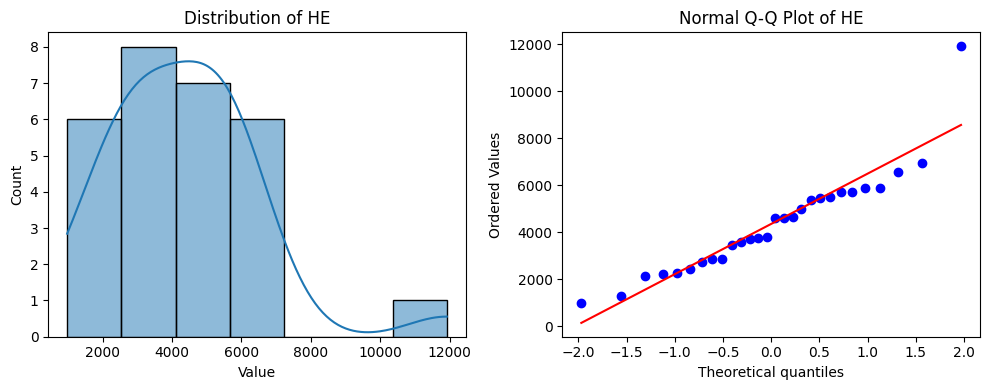


Shapiro-Wilk test for HE:
ShapiroResult(statistic=0.8979354500770569, pvalue=0.01023879088461399)


In [4]:
plt.figure(figsize=(10, 4))
#HE的直方图
plt.subplot(121)
sns.histplot(HE, kde=True)
plt.title('Distribution of HE')
#HE的Q-Q图
plt.subplot(122)
stats.probplot(HE, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of HE')
plt.tight_layout()
plt.show()

# Shapiro-Wilk测试
print("\nShapiro-Wilk test for HE:")
print(shapiro(HE))

In [5]:
# def fit_model(y, X):
#     """拟合模型并计算统计量，包含异方差稳健标准误"""

#     X = np.column_stack((np.ones(len(X)), X))

#     beta = np.linalg.inv(X.T @ X) @ X.T @ y
    
#     y_pred = X @ beta
#     residuals = y - y_pred
    
#     n = len(y)
#     k = X.shape[1]
#     df = n - k
    
#     #异方差稳健标准误 (White's correction)
#     u2 = residuals**2
#     XX_inv = np.linalg.inv(X.T @ X)
#     meat = X.T @ (np.diag(u2) @ X)
#     robust_var = XX_inv @ meat @ XX_inv
#     robust_se = np.sqrt(np.diag(robust_var))
    
#     #使用稳健标准误计算t统计量和p值
#     t_stats = beta / robust_se
#     p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    
#     rss = np.sum(residuals**2)
#     mse = rss / df
#     y_mean = np.mean(y)
#     tss = np.sum((y - y_mean)**2)
#     r_squared = 1 - rss/tss
#     adj_r_squared = 1 - (1 - r_squared) * (n - 1)/(n - k)
#     f_stat = (r_squared/(k-1))/((1-r_squared)/df)
#     f_p_value = 1 - stats.f.cdf(f_stat, k-1, df)
    
#     return {
#         'coefficients': beta,
#         'std_errors': robust_se, 
#         't_stats': t_stats,
#         'p_values': p_values,
#         'r_squared': r_squared,
#         'adj_r_squared': adj_r_squared,
#         'f_stat': f_stat,
#         'f_p_value': f_p_value,
#         'n_obs': n,
#         'df': df,
#         'residuals': residuals,
#         'mse': mse,
#         'y_pred': y_pred
#     }

# def diagnostic_plots(results):
#     """绘制诊断图"""
#     residuals = results['residuals']
#     y_pred = results['y_pred']

#     fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
#     #残差分布图
#     sns.histplot(residuals, kde=True, ax=axes[0,0])
#     axes[0,0].set_title('Residuals Distribution')
#     axes[0,0].set_xlabel('Residuals')
    
#     #QQ图
#     stats.probplot(residuals, dist="norm", plot=axes[0,1])
#     axes[0,1].set_title('Normal Q-Q Plot')
    
#     # 残差vs拟合值
#     axes[1,0].scatter(y_pred, residuals)
#     axes[1,0].axhline(y=0, color='r', linestyle='--')
#     axes[1,0].set_xlabel('Fitted values')
#     axes[1,0].set_ylabel('Residuals')
#     axes[1,0].set_title('Residuals vs Fitted')
    
#     #Scale-Location图
#     axes[1,1].scatter(y_pred, np.sqrt(np.abs(residuals)))
#     axes[1,1].set_xlabel('Fitted values')
#     axes[1,1].set_ylabel('sqrt(|Residuals|)')
#     axes[1,1].set_title('Scale-Location')
    
#     plt.tight_layout()
#     plt.show()

# def print_results(results, var_names):
#     print("="*80)
#     print("Linear Model Results (with Heteroskedasticity-Robust Standard Errors)")
#     print("="*80)
#     print(f"{'Variable':<15} {'Coefficient':>12} {'Robust SE':>12} {'t-value':>12} {'P>|t|':>12} {'Sig':>5}")
#     print("-"*80)
    
#     for i, name in enumerate(var_names):
#         p_value = results['p_values'][i]
#         if p_value <= 0.001:
#             sig = "***"
#         elif p_value <= 0.01:
#             sig = "**"
#         elif p_value <= 0.05:
#             sig = "*"
#         elif p_value <= 0.1:
#             sig = "."
#         else:
#             sig = ""
            
#         print(f"{name:<15} {results['coefficients'][i]:12.4f} {results['std_errors'][i]:12.4f} "
#               f"{results['t_stats'][i]:12.4f} {results['p_values'][i]:12.4f} {sig:>5}")
    
#     print("-"*80)
#     print(f"Observations: {results['n_obs']}")
#     print(f"Degrees of Freedom: {results['df']}")
#     print(f"R-squared: {results['r_squared']:.4f}")
#     print(f"Adj R-squared: {results['adj_r_squared']:.4f}")
#     print(f"F-statistic: {results['f_stat']:.4f}")
#     print(f"Prob (F-statistic): {results['f_p_value']:.6f}")
#     print(f"Residual standard error: {np.sqrt(results['mse']):.4f}")
#     print("="*80)
#     print("Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")
#     print("="*80)

# data = pd.DataFrame({
#     'HE': HE,
#     'GDP': GDP,
#     'DR': DR,
#     'RD': RD,
#     'PH': PH,
#     'GHE': GHE
# })

# data = data.dropna()

# y = data['HE'].values
# X = data[['GDP', 'DR', 'RD', 'PH', 'GHE']].values
# var_names = ['const', 'GDP', 'DR', 'RD', 'PH', 'GHE']

# results = fit_model(y, X)
# print_results(results, var_names)

# residuals = results['residuals']
# print("\nResiduals Summary:")
# print(f"{'Min':>8} {'1Q':>8} {'Median':>8} {'3Q':>8} {'Max':>8}")
# print(f"{np.min(residuals):8.1f} {np.percentile(residuals, 25):8.1f} "
#       f"{np.median(residuals):8.1f} {np.percentile(residuals, 75):8.1f} "
#       f"{np.max(residuals):8.1f}")

# #Shapiro-Wilk检验
# shapiro_stat, shapiro_p = stats.shapiro(residuals)
# print("\nShapiro-Wilk Normality Test:")
# print(f"Statistic: {shapiro_stat:.4f}")
# print(f"p-value: {shapiro_p:.4f}")

# #Breusch-Pagan异方差检验
# X_with_const = np.column_stack((np.ones(len(X)), X))
# bp_test = het_breuschpagan(residuals, X_with_const)
# print("\nBreusch-Pagan Test for Heteroskedasticity:")
# print(f"Statistic: {bp_test[0]:.4f}")
# print(f"p-value: {bp_test[1]:.4f}")

# diagnostic_plots(results)

In [6]:
def fit_model(y, X):
    """拟合模型并计算统计量，使用普通标准误"""
    
    X = np.column_stack((np.ones(len(X)), X))
    beta = np.linalg.inv(X.T @ X) @ X.T @ y

    y_pred = X @ beta
    residuals = y - y_pred
    
    #样本量和自由度
    n = len(y)
    k = X.shape[1]
    df = n - k
    
    rss = np.sum(residuals**2)
    mse = rss / df
    var_beta = mse * np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(var_beta))

    t_stats = beta / se
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    
    y_mean = np.mean(y)
    tss = np.sum((y - y_mean)**2)
    r_squared = 1 - rss/tss
    adj_r_squared = 1 - (1 - r_squared) * (n - 1)/(n - k)
    f_stat = (r_squared/(k-1))/((1-r_squared)/df)
    f_p_value = 1 - stats.f.cdf(f_stat, k-1, df)
    
    return {
        'coefficients': beta,
        'std_errors': se, 
        't_stats': t_stats,
        'p_values': p_values,
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_stat': f_stat,
        'f_p_value': f_p_value,
        'n_obs': n,
        'df': df,
        'residuals': residuals,
        'mse': mse,
        'y_pred': y_pred
    }

def diagnostic_plots(results):
    """绘制图"""
    residuals = results['residuals']
    y_pred = results['y_pred']

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 残差分布图
    sns.histplot(residuals, kde=True, ax=axes[0,0])
    axes[0,0].set_title('Residuals Distribution')
    axes[0,0].set_xlabel('Residuals')
    
    # 残差q-q图
    stats.probplot(residuals, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Residuals Normal Q-Q Plot')
    
    # 残差vs拟合值
    axes[1,0].scatter(y_pred, residuals)
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Fitted values')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Residuals vs Fitted')
    
    # Scale-Location图
    axes[1,1].scatter(y_pred, np.sqrt(np.abs(residuals)))
    axes[1,1].set_xlabel('Fitted values')
    axes[1,1].set_ylabel('sqrt(|Residuals|)')
    axes[1,1].set_title('Scale-Location')
    
    plt.tight_layout()
    plt.show()

def print_results(results, var_names):
    print("="*80)
    print("Linear Model Results")
    print("="*80)
    print(f"{'Variable':<15} {'Coefficient':>12} {'Std.Error':>12} {'t-value':>12} {'P>|t|':>12} {'Sig':>5}")
    print("-"*80)
    
    for i, name in enumerate(var_names):
        p_value = results['p_values'][i]
        if p_value <= 0.001:
            sig = "***"
        elif p_value <= 0.01:
            sig = "**"
        elif p_value <= 0.05:
            sig = "*"
        elif p_value <= 0.1:
            sig = "."
        else:
            sig = ""
            
        print(f"{name:<15} {results['coefficients'][i]:12.4f} {results['std_errors'][i]:12.4f} "
              f"{results['t_stats'][i]:12.4f} {results['p_values'][i]:12.4f} {sig:>5}")
    
    print("-"*80)
    print(f"Observations: {results['n_obs']}")
    print(f"Degrees of Freedom: {results['df']}")
    print(f"R-squared: {results['r_squared']:.4f}")
    print(f"Adj R-squared: {results['adj_r_squared']:.4f}")
    print(f"F-statistic: {results['f_stat']:.4f}")
    print(f"Prob (F-statistic): {results['f_p_value']:.6f}")
    print(f"Residual standard error: {np.sqrt(results['mse']):.4f}")
    print("="*80)
    print("Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")
    print("="*80)


Linear Model Results
Variable         Coefficient    Std.Error      t-value        P>|t|   Sig
--------------------------------------------------------------------------------
const            -42869.1849   11303.0735      -3.7927       0.0010   ***
GDP                4175.2729    1206.5416       3.4605       0.0022    **
DR                  -95.6072     117.6889      -0.8124       0.4253      
RD                  388.5118     255.9506       1.5179       0.1433      
PH                 -340.1625     377.6438      -0.9007       0.3775      
GHE                  80.2822      46.6523       1.7209       0.0993     .
--------------------------------------------------------------------------------
Observations: 28
Degrees of Freedom: 22
R-squared: 0.6594
Adj R-squared: 0.5820
F-statistic: 8.5176
Prob (F-statistic): 0.000132
Residual standard error: 1413.2962
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residuals Summary:
     Min       1Q   Median       3Q      Max
 -1844.9

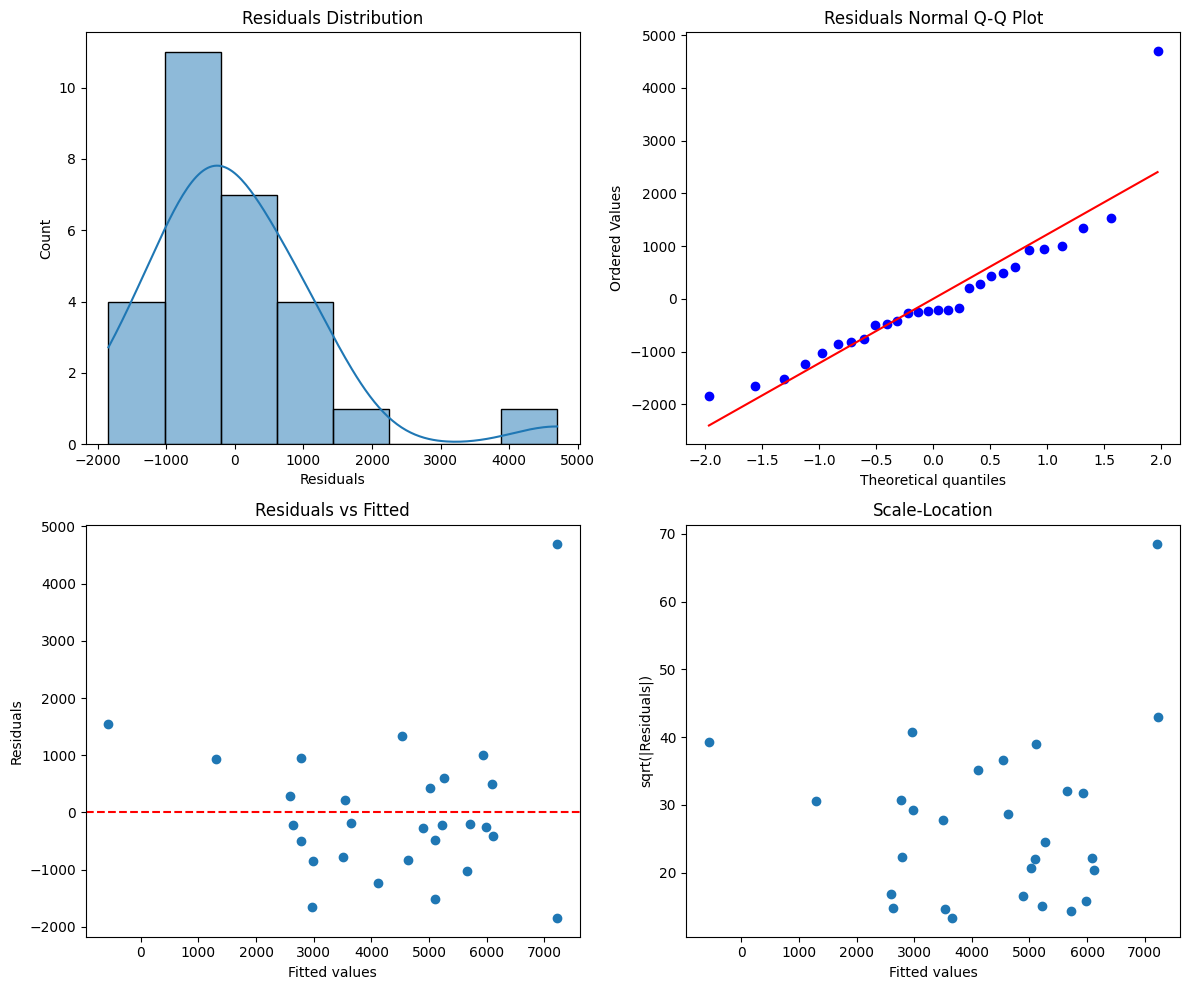

In [7]:
var_names = ['const', 'GDP', 'DR', 'RD', 'PH', 'GHE']
results = fit_model(y, X)
print_results(results, var_names)

residuals = results['residuals']
print("\nResiduals Summary:")
print(f"{'Min':>8} {'1Q':>8} {'Median':>8} {'3Q':>8} {'Max':>8}")
print(f"{np.min(residuals):8.1f} {np.percentile(residuals, 25):8.1f} "
      f"{np.median(residuals):8.1f} {np.percentile(residuals, 75):8.1f} "
      f"{np.max(residuals):8.1f}")

#Shapiro-Wilk检验
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print("\nShapiro-Wilk Test for Residuals:")
print(f"Statistic: {shapiro_stat:.8f}")
print(f"p-value: {shapiro_p:.8f}")

#Breusch-Pagan异方差检验
X_with_const = np.column_stack((np.ones(len(X)), X))
bp_test = het_breuschpagan(residuals, X_with_const)
print("\nBreusch-Pagan Test for Heteroskedasticity:")
print(f"Statistic: {bp_test[0]:.8f}")
print(f"p-value: {bp_test[1]:.8f}")

diagnostic_plots(results)

所以可以考虑对HE进行Box-Cox变换。

In [8]:
def compute_jacobian(y, lambda_param):
    return np.prod(y**(lambda_param - 1))

def boxcox_transform(y, lambda_param):
    """计算Box-Cox变换"""
    if lambda_param == 0:
        return np.log(y)
    else:
        return (y**lambda_param - 1) / lambda_param

def compute_log_likelihood(y, X, lambda_param):
    """计算对数似然函数值"""
    n = len(y)
    y_transformed = boxcox_transform(y, lambda_param)
    X = np.column_stack((np.ones(len(X)), X))
    beta = np.linalg.inv(X.T @ X) @ X.T @ y_transformed
    y_pred = X @ beta
    residuals = y_transformed - y_pred
    sigma2 = np.sum(residuals**2) / n
    
    log_jacobian = np.log(compute_jacobian(y, lambda_param))
    quad_term = np.sum((y_transformed - y_pred)**2)
    ll = -n/2 * np.log(2*np.pi) - n/2 * np.log(sigma2) \
         - quad_term/(2*sigma2) + log_jacobian    
    
    return ll


当λ=-0.1时，似然函数达到最大值，因此对HE采取相应变换得到HE^((-0.1) )。

最优λ值: -0.100
95%置信区间: [-0.470, 0.290]


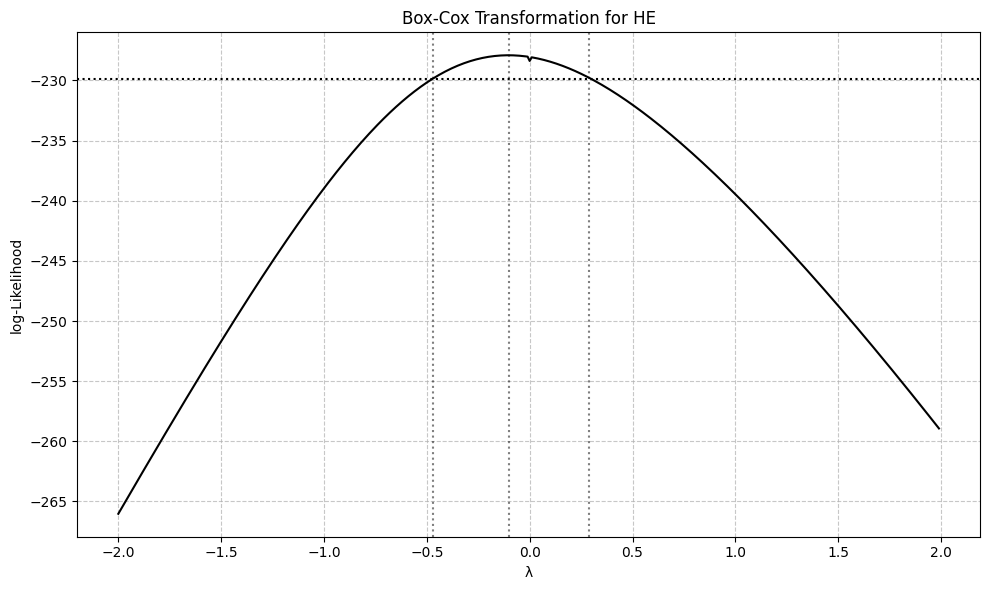

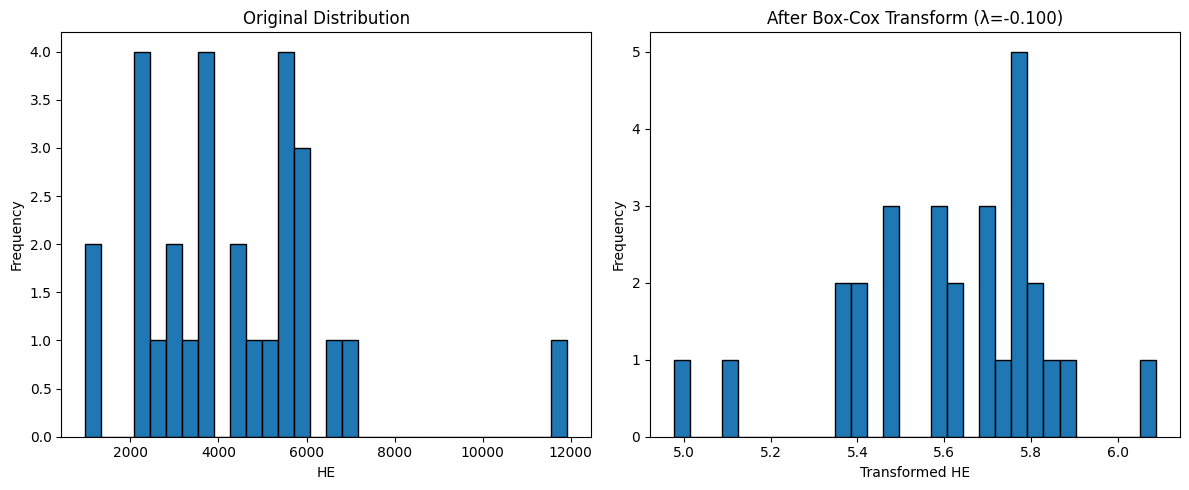

In [9]:
#计算对数似然
fig, ax = plt.subplots(figsize=(10, 6))
lambda_range = np.arange(-2, 2, 0.01)

ll_values = [compute_log_likelihood(y, X, l) for l in lambda_range]
optimal_lambda = lambda_range[np.argmax(ll_values)]
threshold = max(ll_values) - 1.96
ci_indices = np.where(ll_values >= threshold)[0]
ci_lambda_low = lambda_range[ci_indices[0]]
ci_lambda_high = lambda_range[ci_indices[-1]]

ax.plot(lambda_range, ll_values, 'k-')
ax.axhline(y=max(ll_values) - 1.96, color='k', linestyle=':', label='95% CI')
ax.grid(True, linestyle='--', alpha=0.7)
ax.axvline(x=ci_lambda_low, color='k', linestyle=':', alpha=0.5)
ax.axvline(x=optimal_lambda, color='k', linestyle=':', alpha=0.5)
ax.axvline(x=ci_lambda_high, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('λ')
ax.set_ylabel('log-Likelihood')
ax.set_title('Box-Cox Transformation for HE')

print(f"最优λ值: {optimal_lambda:.3f}")
print(f"95%置信区间: [{ci_lambda_low:.3f}, {ci_lambda_high:.3f}]")

plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# 原始数据分布
ax1.hist(y, bins=30, edgecolor='black')
ax1.set_title('Original Distribution')
ax1.set_xlabel('HE')
ax1.set_ylabel('Frequency')
# 转换后数据分布
transformed_y = boxcox_transform(y, optimal_lambda)
ax2.hist(transformed_y, bins=30, edgecolor='black')
ax2.set_title(f'After Box-Cox Transform (λ={optimal_lambda:.3f})')
ax2.set_xlabel('Transformed HE')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

对HE^((-0.1) )进行Shapiro–Wilk检验，p值为0.139，认为变换后因变量HE^((-0.1) )服从正态分布。

In [10]:
HE_new = boxcox_transform(HE, -0.1)
print("\nShapiro-Wilk test for HE_new:")
print(shapiro(HE_new))


Shapiro-Wilk test for HE_new:
ShapiroResult(statistic=0.9438990950584412, pvalue=0.13888218998908997)


考虑HE^((-0.1) )对GDP等自变量的线性回归，回归结果如下所示，其中使用稳健标准误。继续对回归后残差进行Shapiro–Wilk检验，所得p值为0.132，认为残差服从正态分布。注意到，此处变换参数λ=-0.1，与取对数较为接近，与现有文献中常见的对医疗保健支出HE取对数操作一致。

In [11]:
# def fit_model_new(y, X, lambda_param):
#     """拟合模型并计算统计量"""
#     #Box-Cox转换因变量
#     if lambda_param == 0:
#         y_transformed = np.log(y)
#     else:
#         y_transformed = (y**lambda_param - 1) / lambda_param

#     X = np.column_stack((np.ones(len(X)), X))
#     beta = np.linalg.inv(X.T @ X) @ X.T @ y_transformed
    
#     y_pred = X @ beta
#     residuals = y_transformed - y_pred
    
#     #样本量和自由度
#     n = len(y)
#     k = X.shape[1]  # 包括常数项的参数个数
#     df = n - k
    
#     #残差平方和、标准误
#     rss = np.sum(residuals**2)
#     mse = rss / df
#     var_beta = mse * np.linalg.inv(X.T @ X)
#     se = np.sqrt(np.diag(var_beta))

#     t_stats = beta / se
#     p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
#     y_mean = np.mean(y_transformed)
#     tss = np.sum((y_transformed - y_mean)**2)
#     r_squared = 1 - rss/tss
#     adj_r_squared = 1 - (1 - r_squared) * (n - 1)/(n - k)
#     f_stat = (r_squared/(k-1))/((1-r_squared)/df)
#     f_p_value = 1 - stats.f.cdf(f_stat, k-1, df)
    
#     return {
#         'coefficients': beta,
#         'std_errors': se,
#         't_stats': t_stats,
#         'p_values': p_values,
#         'r_squared': r_squared,
#         'adj_r_squared': adj_r_squared,
#         'f_stat': f_stat,
#         'f_p_value': f_p_value,
#         'n_obs': n,
#         'df': df,
#         'residuals': residuals
#     }

# var_names = ['const', 'GDP', 'DR', 'RD', 'PH', 'GHE']
# results = fit_model_new(y, X, 0.1)  # lambda = 0.1

# def print_results_new(results, var_names, model_name):
#     print(f"\n{model_name}")
#     print("="*80)
#     print(f"{'Variable':<15} {'Coefficient':>12} {'Std.Error':>12} {'t-value':>12} {'P>|t|':>12}")
#     print("-"*80)
    
#     for i, name in enumerate(var_names):
#         print(f"{name:<15} {results['coefficients'][i]:12.4f} {results['std_errors'][i]:12.4f} "
#               f"{results['t_stats'][i]:12.4f} {results['p_values'][i]:12.4f}")
    
#     print("-"*80)
#     print(f"Observations: {results['n_obs']}")
#     print(f"Degrees of Freedom: {results['df']}")
#     print(f"R-squared: {results['r_squared']:.4f}")
#     print(f"Adj R-squared: {results['adj_r_squared']:.4f}")
#     print(f"F-statistic: {results['f_stat']:.4f}")
#     print(f"Prob (F-statistic): {results['f_p_value']:.4f}")
#     print("="*80)


# print_results_new(results, var_names, "HE Model (λ = 0.1)")

In [15]:
# def fit_model_new(y, X, lambda_param):
#     """拟合模型并计算稳健统计量"""
#     #Box-Cox转换因变量
#     if lambda_param == 0:
#         y_transformed = np.log(y)
#     else:
#         y_transformed = (y**lambda_param - 1) / lambda_param

#     X = np.column_stack((np.ones(len(X)), X))
#     beta = np.linalg.inv(X.T @ X) @ X.T @ y_transformed
    
#     y_pred = X @ beta
#     residuals = y_transformed - y_pred
    
#     #样本量和自由度
#     n = len(y)
#     k = X.shape[1]  # 包括常数项的参数个数
#     df = n - k
    
#     # 计算稳健标准误
#     u2 = residuals**2
#     XU2X = np.zeros((k, k))
#     for i in range(n):
#         XU2X += np.outer(X[i], X[i]) * u2[i]
    
#     XX_inv = np.linalg.inv(X.T @ X)
#     var_beta_robust = XX_inv @ XU2X @ XX_inv
#     se_robust = np.sqrt(np.diag(var_beta_robust))
    
#     t_stats = beta / se_robust
#     p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df))
    
#     y_mean = np.mean(y_transformed)
#     tss = np.sum((y_transformed - y_mean)**2)
#     rss = np.sum(residuals**2)
#     r_squared = 1 - rss/tss
#     adj_r_squared = 1 - (1 - r_squared) * (n - 1)/(n - k)
#     f_stat = (r_squared/(k-1))/((1-r_squared)/df)
#     f_p_value = 1 - stats.f.cdf(f_stat, k-1, df)
    
#     return {
#         'coefficients': beta,
#         'std_errors': se_robust, 
#         't_stats': t_stats,
#         'p_values': p_values,
#         'r_squared': r_squared,
#         'adj_r_squared': adj_r_squared,
#         'f_stat': f_stat,
#         'f_p_value': f_p_value,
#         'n_obs': n,
#         'df': df,
#         'residuals': residuals
#     }

# var_names = ['const', 'GDP', 'DR', 'RD', 'PH', 'GHE']
# results = fit_model_new(y, X, 0.1)  # lambda = 0.1

# def print_results_new(results, var_names, model_name):
#     print(f"\n{model_name}")
#     print("="*80)
#     print(f"{'Variable':<15} {'Coefficient':>12} {'Robust SE':>12} {'t-value':>12} {'P>|t|':>12}")
#     print("-"*80)
    
#     for i, name in enumerate(var_names):
#         print(f"{name:<15} {results['coefficients'][i]:12.4f} {results['std_errors'][i]:12.4f} "
#               f"{results['t_stats'][i]:12.4f} {results['p_values'][i]:12.4f}")
    
#     print("-"*80)
#     print(f"Observations: {results['n_obs']}")
#     print(f"Degrees of Freedom: {results['df']}")
#     print(f"R-squared: {results['r_squared']:.4f}")
#     print(f"Adj R-squared: {results['adj_r_squared']:.4f}")
#     print(f"F-statistic: {results['f_stat']:.4f}")
#     print(f"Prob (F-statistic): {results['f_p_value']:.4f}")
#     print("="*80)

# print_results_new(results, var_names, "HE Model (λ = 0.1)")

                            OLS Regression Results                            
Dep. Variable:                 HE_new   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     57.66
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           6.63e-12
Time:                        22:03:48   Log-Likelihood:                 26.362
No. Observations:                  28   AIC:                            -40.72
Df Residuals:                      22   BIC:                            -32.73
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6751      1.278     -0.528      0.5

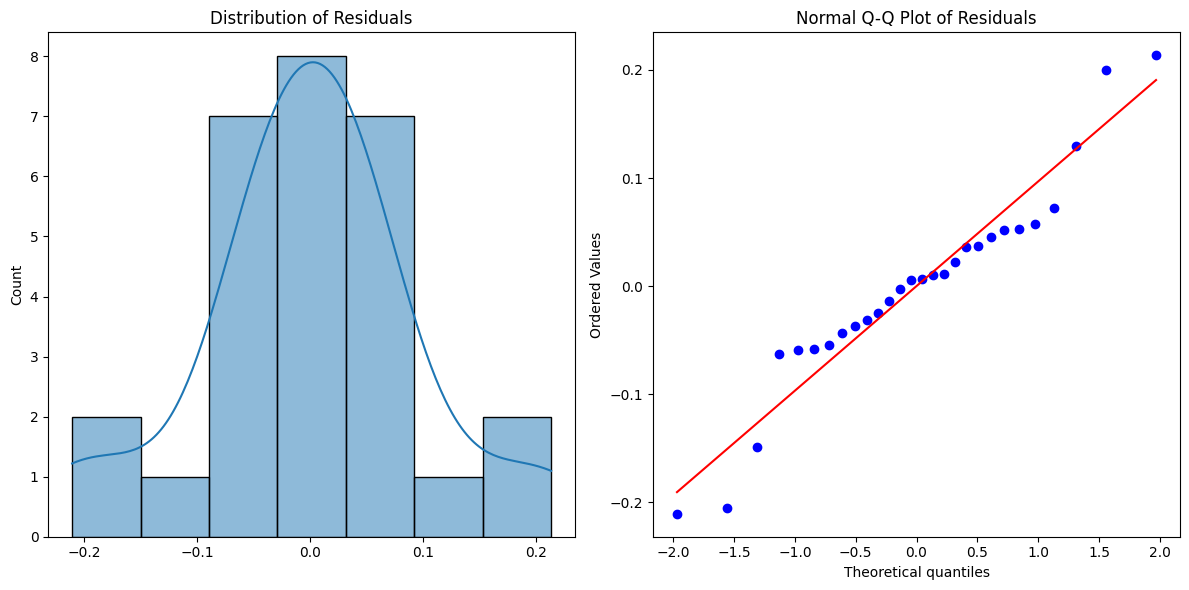


Shapiro-Wilk test for residuals:
ShapiroResult(statistic=0.9429986476898193, pvalue=0.13175375759601593)


In [16]:
data1 = pd.DataFrame({'HE_new': HE_new, 'GDP': GDP, 'DR': DR, 'RD': RD, 'PH': PH, 'GHE': GHE})
X = data1[['GDP', 'DR', 'RD', 'PH', 'GHE']]
X = sm.add_constant(X)
y = data1['HE_new']
model1 = sm.OLS(y, X).fit(cov_type='HC0')
print(model1.summary())

residuals = model1.resid
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

print("\nShapiro-Wilk test for residuals:")
print(shapiro(residuals))

In [14]:
# residuals = results['residuals']

# plt.figure(figsize=(12, 5))
# #分布图
# plt.subplot(121)
# sns.histplot(residuals, kde=True,  bins=20)
# plt.title('Residuals Distribution')
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.xticks(np.arange(-2, 2.5, 0.5))
# #Q-Q图
# plt.subplot(122)
# stats.probplot(residuals, dist="norm", plot=plt)
# plt.title('Residuals Q-Q Plot')

# plt.tight_layout()
# plt.show()

# # Shapiro-Wilk检验
# #print(shapiro(residuals))
# stat, p_value = shapiro(residuals)
# print("\nShapiro-Wilk Test for Residuals:")
# print(f"统计量: {stat:.8f}")
# print(f"p值: {p_value:.8f}")
# print(f"结论: {'拒绝正态性假设' if p_value < 0.05 else '不能拒绝正态性假设'} (α = 0.05)")